<a href="https://colab.research.google.com/github/Arif111866/Deep-Learning-AI/blob/main/Assignment_9/Task_1_Assignment_9_DNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Task___1, just extruct the feature by autoencode and plot in a 2D map

In [ ]:
pip install torch

In [ ]:
pip install torchvision

In [ ]:
pip install matplotlib

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np


In [5]:
class Autoencoder2D(nn.Module):
    def __init__(self):
        super(Autoencoder2D, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, 3, stride=2, padding=1),  # 16x16
            nn.ReLU(True),
            nn.Conv2d(32, 64, 3, stride=2, padding=1),  # 8x8
            nn.ReLU(True),
            nn.Conv2d(64, 128, 3, stride=2, padding=1),  # 4x4
            nn.ReLU(True),
            nn.Flatten(),
            nn.Linear(128 * 4 * 4, 2)  # Bottleneck layer with 2 features
        )
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(2, 128 * 4 * 4),
            nn.ReLU(True),
            nn.Unflatten(1, (128, 4, 4)),
            nn.ConvTranspose2d(128, 64, 3, stride=2, output_padding=1, padding=1),  # 8x8
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 32, 3, stride=2, output_padding=1, padding=1),  # 16x16
            nn.ReLU(True),
            nn.ConvTranspose2d(32, 3, 3, stride=2, output_padding=1, padding=1),  # 32x32
            nn.Sigmoid()
        )

    def forward(self, x):
        z = self.encoder(x)
        out = self.decoder(z)
        return out

    def encode(self, x):
        return self.encoder(x)


In [6]:
transform = transforms.Compose([
    transforms.ToTensor()
])

train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)

test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)


100%|██████████| 170M/170M [00:04<00:00, 42.3MB/s]


In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Autoencoder2D().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Training loop
num_epochs = 20
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for imgs, _ in train_loader:
        imgs = imgs.to(device)
        outputs = model(imgs)
        loss = criterion(outputs, imgs)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}")


Epoch [1/20], Loss: 0.0400
Epoch [2/20], Loss: 0.0369
Epoch [3/20], Loss: 0.0367
Epoch [4/20], Loss: 0.0366
Epoch [5/20], Loss: 0.0366
Epoch [6/20], Loss: 0.0365
Epoch [7/20], Loss: 0.0365
Epoch [8/20], Loss: 0.0364
Epoch [9/20], Loss: 0.0364
Epoch [10/20], Loss: 0.0364
Epoch [11/20], Loss: 0.0363
Epoch [12/20], Loss: 0.0363
Epoch [13/20], Loss: 0.0363
Epoch [14/20], Loss: 0.0362
Epoch [15/20], Loss: 0.0362
Epoch [16/20], Loss: 0.0361
Epoch [17/20], Loss: 0.0361
Epoch [18/20], Loss: 0.0361
Epoch [19/20], Loss: 0.0360
Epoch [20/20], Loss: 0.0360


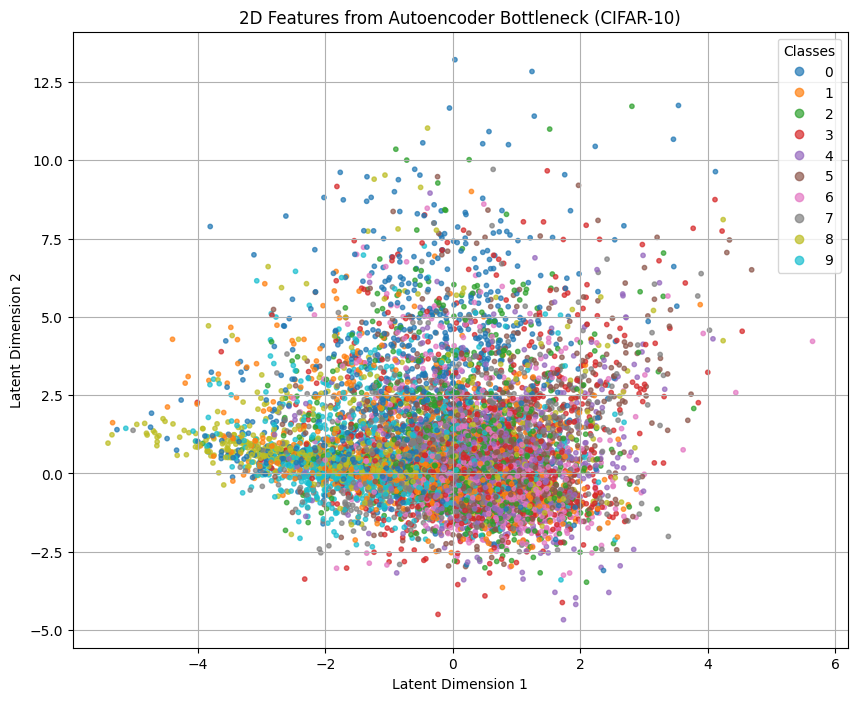

In [11]:
model.eval()
features = []
labels = []

with torch.no_grad():
    for imgs, lbls in test_loader:
        imgs = imgs.to(device)
        z = model.encode(imgs)
        features.append(z.cpu().numpy())
        labels.append(lbls.numpy())

features = np.concatenate(features, axis=0)
labels = np.concatenate(labels, axis=0)

plt.figure(figsize=(10, 8))
scatter = plt.scatter(features[:, 0], features[:, 1], c=labels, cmap='tab10', alpha=0.7, s=10)
plt.legend(*scatter.legend_elements(), title="Classes")
plt.title("2D Features from Autoencoder Bottleneck (CIFAR-10)")
plt.xlabel("Latent Dimension 1")
plt.ylabel("Latent Dimension 2")
plt.grid(True)
plt.show()
